In [1]:
import re

from bs4 import BeautifulSoup
import requests
import tqdm

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

# Data Collecting and Saving

In [2]:
USER_AGENT = 'Safari/537.36'

def get_soup(url):
    headers = {"User-Agent": USER_AGENT}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'lxml')
    return soup

In [3]:
def extract_vacancy_description(vacancy_url):
    vacancy_soup = get_soup(vacancy_url)
    description_div = vacancy_soup.find('div', class_='text')
    description = description_div.text.strip()
    return description

In [4]:
PAGE_URL_TEMPLATE = 'https://gojob.az/vacancy/list?categories=web-ve-proqramlasdirma&page={page}'
PAGES_COUNT = 27

In [5]:
vacancies = []

In [6]:
for page_numb in range(1, PAGES_COUNT + 1):
    page_soup = get_soup(PAGE_URL_TEMPLATE.format(page=page_numb))

    vacancy_link_tags = page_soup.select('div.app-item-content > div.item > a')
    pbar = tqdm.tqdm(vacancy_link_tags, desc=f"Page {page_numb}")
    
    for vacancy_link_tag in pbar:
        vacancy_url = vacancy_link_tag.get('href')
        description = extract_vacancy_description(vacancy_url)
        vacancies.append(description)                

Page 27: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]


In [7]:
len(vacancies)

525

In [8]:
df = pd.DataFrame(vacancies, columns=['description'])

In [9]:
df.shape

(525, 1)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.shape

(493, 1)

In [12]:
df.head()

,description
0,MPAY QSCVəzifə adı: Proqram təminatının testi ...
1,Bazar riskləri şöbəsinin aparıcı /Baş mütəxəss...
2,Company Project : Local E -commercePosition : ...
3,1996-cı ildə əsası qoyulan Sinteks Şirkətlər Q...
4,“Grand Motors” MMC 2005-ci ilin sentyabr ayınd...


In [13]:
df.to_csv('vacancies.csv', index=False)

In [14]:
!ls

main.ipynb
vacancies.csv


# Analysis

### 1. First delete unrelated job vacancies where programming languages aren't mentioned

In [15]:
jobs_df = pd.read_csv('vacancies.csv')

In [16]:
jobs_df.head()

,description
0,MPAY QSCVəzifə adı: Proqram təminatının testi ...
1,Bazar riskləri şöbəsinin aparıcı /Baş mütəxəss...
2,Company Project : Local E -commercePosition : ...
3,1996-cı ildə əsası qoyulan Sinteks Şirkətlər Q...
4,“Grand Motors” MMC 2005-ci ilin sentyabr ayınd...


In [17]:
jobs_df.shape

(493, 1)

In [18]:
jobs_df['description'] = jobs_df['description'].str.lower()

In [19]:
jobs_df.head()

,description
0,mpay qscvəzifə adı: proqram təminatının testi ...
1,bazar riskləri şöbəsinin aparıcı /baş mütəxəss...
2,company project : local e -commerceposition : ...
3,1996-cı ildə əsası qoyulan sinteks şirkətlər q...
4,“grand motors” mmc 2005-ci ilin sentyabr ayınd...


In [20]:
prog_lang_rows = []

In [21]:
PROGRAMMING_LANGUAGES = ['java', 'c#', 'javascript', 'kotlin', 'swift', 'python', 'php']

for row in jobs_df['description']:
    languages_in_row = [re.search(lang, row) for lang in PROGRAMMING_LANGUAGES]
    if not all(lang is None for lang in languages_in_row):
        prog_lang_rows.append(row)

In [22]:
print(len(prog_lang_rows))

258


In [23]:
langs_df = pd.DataFrame(prog_lang_rows, columns=['description'])

In [24]:
langs_df.head()

,description
0,mpay qscvəzifə adı: proqram təminatının testi ...
1,company project : local e -commerceposition : ...
2,1996-cı ildə əsası qoyulan sinteks şirkətlər q...
3,web developerосновные обязанности и обязательс...
4,mpay qscios native developer - ios (swift) pro...


In [25]:
langs_df.shape

(258, 1)

### 2. Now let's answer the question "How many vacancies are there for each progamming language?"

In [26]:
langs_df.head()

,description
0,mpay qscvəzifə adı: proqram təminatının testi ...
1,company project : local e -commerceposition : ...
2,1996-cı ildə əsası qoyulan sinteks şirkətlər q...
3,web developerосновные обязанности и обязательс...
4,mpay qscios native developer - ios (swift) pro...


In [27]:
langs_data = []

In [28]:
for lang in PROGRAMMING_LANGUAGES:
    lang_mask = langs_df['description'].str.contains(lang)
    lang_vacancies = langs_df[lang_mask].shape[0]
    lang_data = {'language': lang, 'vacancies': lang_vacancies}
    langs_data.append(lang_data)

In [29]:
langs_data

[{'language': 'java', 'vacancies': 177},
 {'language': 'c#', 'vacancies': 73},
 {'language': 'javascript', 'vacancies': 116},
 {'language': 'kotlin', 'vacancies': 11},
 {'language': 'swift', 'vacancies': 13},
 {'language': 'python', 'vacancies': 49},
 {'language': 'php', 'vacancies': 60}]

In [30]:
lang_freq_df = pd.DataFrame(sorted(
    langs_data, 
    key=lambda language: language['vacancies'], 
    reverse=True
))

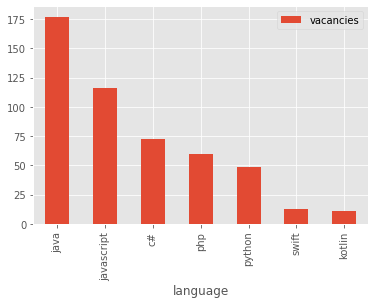

In [31]:
lang_freq_df.plot(x='language', y='vacancies', kind='bar')
plt.show()